In [2]:
# 1️⃣ Importar librerías
import os
import sys
import pandas as pd

# -------------------------------------------------------------
# 2️⃣ Configuración de Variables de Entorno
# -------------------------------------------------------------
def get_required_env(var_name):
    value = os.environ.get(var_name)
    if not value:
        print(f"FATAL ERROR: La variable de entorno requerida '{var_name}' no está configurada o es nula.", file=sys.stderr)
        sys.exit(1)
    return value

BUCKET_NAME_GOLD = get_required_env("BUCKET_NAME_GOLD")
AWS_ACCESS_KEY_ID = get_required_env("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = get_required_env("AWS_SECRET_ACCESS_KEY")



In [3]:
INPUT_PATH_DAILY = f"s3://{BUCKET_NAME_GOLD}/gold/resumen_clima_diario/"
INPUT_PATH_PATTERNS = f"s3://{BUCKET_NAME_GOLD}/gold/patrones_horarios/"

# Opciones de S3
storage_options = {
    "key": AWS_ACCESS_KEY_ID,
    "secret": AWS_SECRET_ACCESS_KEY
}


In [4]:
print(f"✅ Rutas configuradas: {INPUT_PATH_DAILY} | {INPUT_PATH_PATTERNS}")

✅ Rutas configuradas: s3://infraestructura-datos-gold/gold/resumen_clima_diario/ | s3://infraestructura-datos-gold/gold/patrones_horarios/


In [5]:
def safe_read_parquet(path):
    try:
        df = pd.read_parquet(path, storage_options=storage_options)
        if df.empty:
            print(f"❌ ERROR: La tabla en '{path}' está vacía.", file=sys.stderr)
            sys.exit(1)
        return df
    except Exception as e:
        print(f"❌ ERROR: No se pudo leer la tabla en '{path}'. Detalle: {e}", file=sys.stderr)
        sys.exit(1)

print("📥 Cargando datos desde GOLD...")
df_daily = safe_read_parquet(INPUT_PATH_DAILY)
df_patterns = safe_read_parquet(INPUT_PATH_PATTERNS)
print(f"✅ Registros diarios: {len(df_daily):,}")
print(f"✅ Registros patrones: {len(df_patterns):,}")

📥 Cargando datos desde GOLD...
✅ Registros diarios: 740
✅ Registros patrones: 626


In [6]:
# Días con mayor y menor potencial
max_eolico = df_daily.loc[df_daily["max_potencial_eolico_diario"].idxmax()]
max_solar = df_daily.loc[df_daily["max_potencial_solar_diario"].idxmax()]
min_eolico_prom = df_daily.loc[df_daily["promedio_potencial_eolico_diario"].idxmin()]
min_solar_prom = df_daily.loc[df_daily["promedio_potencial_solar_diario"].idxmin()]

# Patrones horarios
patron_eolico_max = df_patterns.groupby("hora_solo", observed=False)["promedio_eolico_por_hora_mes"].mean().idxmax()
prom_eolico_max = round(df_patterns.groupby("hora_solo", observed=False)["promedio_eolico_por_hora_mes"].mean().max(), 2)

patron_solar_max = df_patterns.groupby("hora_solo", observed=False)["promedio_solar_por_hora_mes"].mean().idxmax()
prom_solar_max = round(df_patterns.groupby("hora_solo", observed=False)["promedio_solar_por_hora_mes"].mean().max(), 2)

# Días de lluvia vs potencial solar
dia_mas_lluvioso = df_daily.loc[df_daily["total_precipitacion_diaria_mm"].idxmax()]

# Condiciones extremas
ciudad_max_temp = df_daily.loc[df_daily["max_temperatura_registro_c"].idxmax()]
ciudad_min_temp = df_daily.loc[df_daily["min_temperatura_registro_c"].idxmin()]

ciudad_max_humedad = df_daily.groupby("ciudad", observed=False)["promedio_humedad_diaria"].mean().idxmax()
prom_humedad_max = round(df_daily.groupby("ciudad", observed=False)["promedio_humedad_diaria"].mean().max(), 2)


In [7]:
reporte = f"""
# Reporte Analítico de Potencial Energético

## 1. Resumen de Potenciales Extremos

| Potencial | Ciudad | Fecha | Valor Máximo/Mínimo |
| :--- | :--- | :--- | :--- |
| **Eólico Máximo** | {max_eolico['ciudad']} | {max_eolico['fecha_solo']} | {max_eolico['max_potencial_eolico_diario']} |
| **Solar Máximo** | {max_solar['ciudad']} | {max_solar['fecha_solo']} | {max_solar['max_potencial_solar_diario']} |
| Eólico Mínimo (Promedio) | {min_eolico_prom['ciudad']} | {min_eolico_prom['fecha_solo']} | {min_eolico_prom['promedio_potencial_eolico_diario']} |
| Solar Mínimo (Promedio) | {min_solar_prom['ciudad']} | {min_solar_prom['fecha_solo']} | {min_solar_prom['promedio_potencial_solar_diario']} |

## 2. Patrones Horarios

* **Eólico:** Hora pico {patron_eolico_max}:00 con promedio {prom_eolico_max} WPI
* **Solar:** Hora pico {patron_solar_max}:00 con promedio {prom_solar_max} SPI

## 3. Correlación lluvia vs potencial solar

* Día más lluvioso: {dia_mas_lluvioso['fecha_solo']} en {dia_mas_lluvioso['ciudad']} con {dia_mas_lluvioso['total_precipitacion_diaria_mm']} mm
* Potencial solar promedio ese día: {dia_mas_lluvioso['promedio_potencial_solar_diario']} SPI

## 4. Condiciones extremas

* Temperatura máxima: {ciudad_max_temp['ciudad']} ({ciudad_max_temp['fecha_solo']}): {ciudad_max_temp['max_temperatura_registro_c']} °C
* Temperatura mínima: {ciudad_min_temp['ciudad']} ({ciudad_min_temp['fecha_solo']}): {ciudad_min_temp['min_temperatura_registro_c']} °C
* Mayor promedio de humedad: {ciudad_max_humedad} ({prom_humedad_max}%)
"""

print(reporte)


# Reporte Analítico de Potencial Energético

## 1. Resumen de Potenciales Extremos

| Potencial | Ciudad | Fecha | Valor Máximo/Mínimo |
| :--- | :--- | :--- | :--- |
| **Eólico Máximo** | Patagonia | 2025-05-03 | 29.36 |
| **Solar Máximo** | Patagonia | 2024-12-26 | 13.0 |
| Eólico Mínimo (Promedio) | Patagonia | 2025-06-09 | 0.01 |
| Solar Mínimo (Promedio) | Patagonia | 2025-08-01 | 0.0 |

## 2. Patrones Horarios

* **Eólico:** Hora pico 19:00 con promedio 2.49 WPI
* **Solar:** Hora pico 18:00 con promedio 5.04 SPI

## 3. Correlación lluvia vs potencial solar

* Día más lluvioso: 2024-11-01 en Riohacha con 639.81 mm
* Potencial solar promedio ese día: 1.87 SPI

## 4. Condiciones extremas

* Temperatura máxima: Riohacha (2024-08-20): 34.69 °C
* Temperatura mínima: Patagonia (2025-06-29): -15.01 °C
* Mayor promedio de humedad: Riohacha (76.09%)



<Figure size 640x480 with 0 Axes>

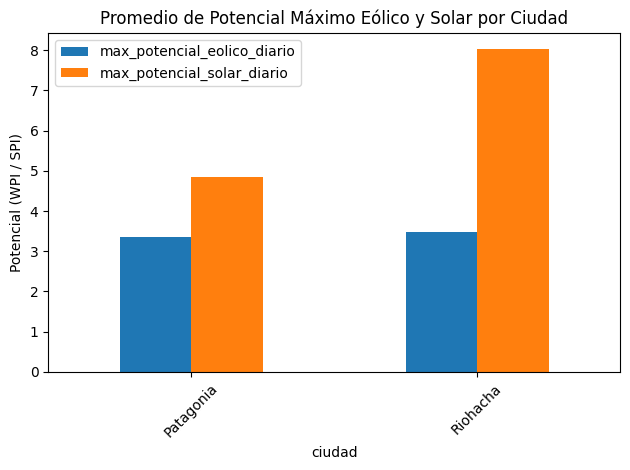

In [ ]:
# 4.1 Gráfico: Potencial Eólico vs Solar por Ciudad
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
df_daily.groupby("ciudad", observed=False)[["max_potencial_eolico_diario","max_potencial_solar_diario"]].mean() \
    .sort_values("max_potencial_eolico_diario", ascending=False) \
    .plot(kind="bar")
plt.title("Promedio de Potencial Máximo Eólico y Solar por Ciudad")
plt.ylabel("Potencial (WPI / SPI)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

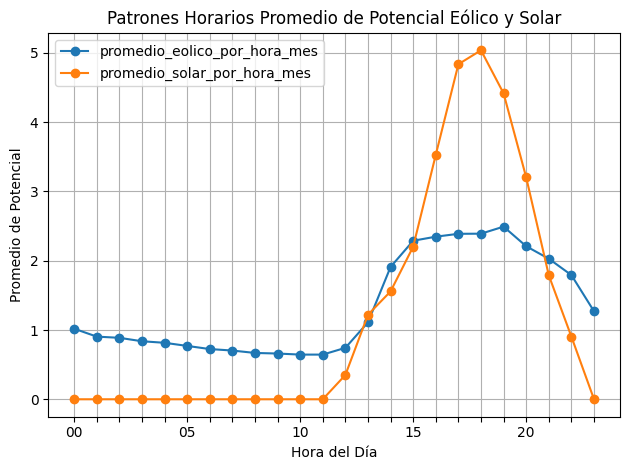

In [9]:
# 4.2 Gráfico: Patrones Horarios Eólico y Solar
plt.figure()
patrones_df = df_patterns.groupby("hora_solo", observed=False)[["promedio_eolico_por_hora_mes","promedio_solar_por_hora_mes"]].mean()
patrones_df.plot(kind="line", marker="o")
plt.title("Patrones Horarios Promedio de Potencial Eólico y Solar")
plt.xlabel("Hora del Día")
plt.ylabel("Promedio de Potencial")
plt.grid(True)
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

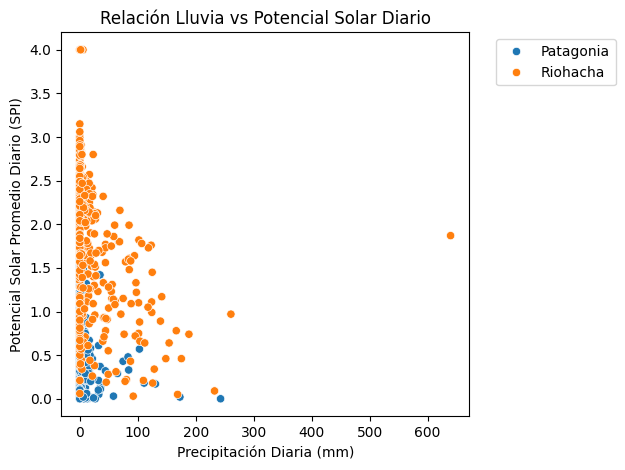

In [10]:
# 4.3 Gráfico: Precipitación vs Potencial Solar
plt.figure()
sns.scatterplot(data=df_daily, x="total_precipitacion_diaria_mm", y="promedio_potencial_solar_diario", hue="ciudad", palette="tab10")
plt.title("Relación Lluvia vs Potencial Solar Diario")
plt.xlabel("Precipitación Diaria (mm)")
plt.ylabel("Potencial Solar Promedio Diario (SPI)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

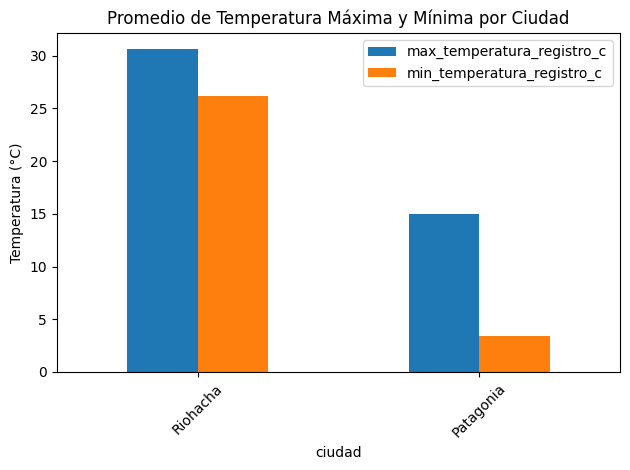

In [11]:
# 4.4 Gráfico: Temperaturas Extrema
plt.figure()
df_daily.groupby("ciudad", observed=False)[["max_temperatura_registro_c","min_temperatura_registro_c"]].mean() \
    .sort_values("max_temperatura_registro_c", ascending=False) \
    .plot(kind="bar")
plt.title("Promedio de Temperatura Máxima y Mínima por Ciudad")
plt.ylabel("Temperatura (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()